In [ ]:
# !pip install -q hvplot
# !pip install --upgrade pandas
# !pip install --upgrade pandas-datareader
# !pip install -q yfinance
# !pip install catboost
# !pip install xgboost
# !pip install ThymeBoost

In [ ]:
# !git clone https://github.com/jeslago/epftoolbox.git

In [ ]:
# %cd epftoolbox
# !python setup.py install

In [ ]:
import math
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
sns.set_style('whitegrid')
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
plt.rcParams.update({'font.size': 22})
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader

# Pre-processing
from ThymeBoost import ThymeBoost as tb
from scipy import stats
from scipy.stats import norm
from scipy.stats.mstats import winsorize

from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import RFE
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer

# Forecasting method
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.ensemble import AdaBoostRegressor

# Accuracy metric 
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, roc_auc_score

# Lain-lain
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
from scipy.stats import kurtosis, skew
from sklearn import linear_model

In [ ]:
# Get data AAPL from yfinance
AAPL = DataReader('AAPL', data_source='yahoo', start='1992-01-01', end='2022-01-01')
AAPL.columns = AAPL.columns.str.replace(" ", "")
# AAPL = AAPL.loc[:, AAPL.columns != 'Volume']

In [ ]:
week = pd.DataFrame(data=AAPL, columns=AAPL.columns) 

In [ ]:
week['Date'] = pd.to_datetime(week.index) - pd.to_timedelta(7, unit='d')
week = week.groupby([pd.Grouper(key='Date', freq='W')])[week.columns].sum().reset_index().sort_values('Date')

In [ ]:
month = pd.DataFrame(data=AAPL, columns=AAPL.columns) 

In [ ]:
month['Date'] = pd.to_datetime(month.index) - pd.to_timedelta(7, unit='d')
month = month.groupby([pd.Grouper(key='Date', freq='M')])[month.columns].sum().reset_index().sort_values('Date')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# AAPL.to_csv('stock_price.csv', sep='\t')

In [ ]:
class GetRidofOutlier:
  def __init__(self, df, col):
    self.df = df
    self.col = col

  def tukeys_method(self):
    q1 = self.df[self.col].quantile(0.25)
    q3 = self.df[self.col].quantile(0.75)
    
    iqr = q3-q1
    inner_fence = 1.5*iqr
    outer_fence = 3*iqr
    
    inner_fence_le = q1-inner_fence
    inner_fence_ue = q3+inner_fence

    outer_fence_le = q1-outer_fence
    outer_fence_ue = q3+outer_fence
    
    outliers_prob = []
    outliers_poss = []

    for index, x in enumerate(self.df[self.col]):
        if x <= outer_fence_le or x >= outer_fence_ue:
            outliers_prob.append(index)
    for index, x in enumerate(self.df[self.col]):
        if x <= inner_fence_le or x >= inner_fence_ue:
            outliers_poss.append(index)

    return outliers_prob, outliers_poss

  def robust(self):
    model = RobustScaler(
        with_centering=True, 
        with_scaling=True, 
        quantile_range=(25.0, 75.0), 
        copy=True)
    robust_df = model.fit_transform(self.df.values)
    robust_df = pd.DataFrame(robust_df, columns = self.df.columns )
    
    return robust_df

  def standard(self):
    scaler = StandardScaler()
    # self.df.set_index('Date', inplace=True) 
    standard_df = scaler.fit_transform(self.df.values)
    standard_df = pd.DataFrame(standard_df, columns = self.df.columns)

    return standard_df
    
  def minmax(self, i=0):
    scaler = MinMaxScaler(feature_range=(0, 1))
    # self.df.set_index('Date', inplace=True) 
    minmax_df = []
    if i==1:
      minmax_df = scaler.fit_transform(self.df.values)
      minmax_df = pd.DataFrame(minmax_df, columns = self.df.columns)
    else:
      minmax_df = scaler.inverse_transform(self.df.values)
      minmax_df = pd.DataFrame(minmax_df, columns = self.df.columns)

    return minmax_df

  def power(self):
    scaler = PowerTransformer(method = 'yeo-johnson')
    # self.df.set_index('Date', inplace=True) 
    power_df = scaler.fit_transform(self.df.values)
    power_df = pd.DataFrame(power_df, columns = self.df.columns)

    return power_df

  def outliers_to_nan(self, probable_outliers):
    self.df.Close.iloc[probable_outliers] = None
    self.df.reset_index(inplace=True)
    return self.df
  
  def thyme_outlier(self):
    model = tb.ThymeBoost()
    output = model.detect_outliers(
        self.df[self.col], 
        trend_estimator='linear', 
        seasonal_estimator='fourier', 
        global_cost='maicc', 
        fit_type='global', 
        seasonality_weights='regularize')
    output = output.rename(columns={'y':'Close'})
    
    return output

  def impute(self):
    imputer = IterativeImputer(
        estimator=BayesianRidge(), 
        initial_strategy='mean', 
        n_nearest_features=None, 
        imputation_order='ascending')
    # self.df.set_index('Date', inplace=True)  
    imputer.fit(self.df)
    df_imp_tf = imputer.transform(self.df)
    df_imp = pd.DataFrame(df_imp_tf, columns = self.df.columns)

    return df_imp

In [ ]:
grid_params = {
  'max_depth': [3, 5, 10],
  'bagging_freq': [5, 10, 20], 
  'bagging_fraction': [0.5, 0.75, 0.95],
  'n_estimators': [100, 200, 1000],
  'metric': ['rmse'],
  'learning_rate': [0.1, 0.01, 0.001],
  'boosting_type': ['dart', 'gbdt', 'rf'] # goss
  }

In [ ]:
dt_params = {
  'max_bin': 3,
}

In [ ]:
# lgbm hyperparameter
lgbm_params = {
  'max_depth': 1,
  'bagging_freq': 20, 
  'bagging_fraction': 0.95,
  'n_estimators': 100,
  'learning_rate': 0.1,
  'boosting_type': 'dart',
  'objective': 'regression_l1',
  }

In [ ]:
xgb_params = {
  'max_depth': 1,
  'objective': 'reg:linear',
  'eta': 0.1,
  'sampling_method': 'gradient_based',
  'subsample': 0.1,
  'colsample_bytree':0.1, 'colsample_bylevel':0.1, 'colsample_bynode':0.1,
  'min_child_weight': 2, 
}

In [ ]:
cat_params = {
  'n_estimators': 100, 
  'eta': 0.01,
  'logging_level':'Verbose',
  'metric_period': 100,  
}

In [ ]:
ada_params = {
  'n_estimators':  100, 
  'learning_rate': 0.01,
  'loss': 'linear',
}

In [ ]:
class Folds:
  def __init__(self, train_x, train_y, val_x, val_y, test_x):
    self.train_x = train_x
    self.train_y = train_y
    self.val_x = val_x
    self.val_y = val_y
    self.test_x = test_x

  def lgbm_tuning(self):
    folds = KFold(5)
    train_x = self.train_x.append(self.val_x, ignore_index=True)
    train_y = self.train_y.append(self.val_y, ignore_index=True)

    model = lgb.LGBMRegressor(objective='regression_l2')
    model.fit(train_x, train_y)
  
    model_cv = GridSearchCV(estimator = model, cv=folds, param_grid = grid_params, verbose = 1, return_train_score=True) 
    model_cv.fit(train_x, train_y)
    cv_results = pd.DataFrame(model_cv.cv_results_)
    
    return cv_results

  def lgbm_fold(self):
    train = lgb.Dataset(self.train_x, label=self.train_y)
    val = lgb.Dataset(self.val_x, label=self.val_y)

    model  = lgb.train(lgbm_params, train, 7000, valid_sets=[val], early_stopping_rounds=100, verbose_eval=100)
    pred_test_y = model.predict(self.test_x, num_iteration=model.best_iteration)
    pred_val_y = model.predict(self.val_x, num_iteration=model.best_iteration)

    return model, pred_test_y, pred_val_y


In [ ]:
class Prediction:
  def __init__(self, train_x, test_x, train_y, test_y, val_x, val_y, df):
    self.train_x = train_x
    self.train_y = train_y
    self.test_x = test_x
    self.test_y = test_y
    self.val_x = val_x
    self.val_y = val_y
    self.df = df

  def lgbm(self):
    kf = KFold(n_splits=5)
    meong_x, meong_y = pd.concat([self.train_x, self.val_x]), pd.concat([self.train_y, self.val_y])

    train = lgb.Dataset(self.train_x, label=self.train_y, params=dt_params)
    val = lgb.Dataset(self.val_x, label=self.val_y)
    cv = lgb.LGBMRegressor()
    cv.fit(self.train_x, self.train_y, eval_set=[(self.val_x, self.val_y)])

    model  = lgb.train(lgbm_params, train, valid_sets=[val], early_stopping_rounds=50)
    prediction = model.predict(self.test_x)
    scores = cross_val_score(cv, meong_x, meong_y, cv=kf)

    return prediction, scores

  def catboost(self):
    model =  CatBoostRegressor(**cat_params)
    model.fit(self.train_x, self.train_y, eval_set=(self.val_x, self.val_y), early_stopping_rounds=50)
    prediction = model.predict(self.test_x)

    return prediction

  def xgboost(self):
    kf = KFold(n_splits=5)
    meong_x, meong_y = pd.concat([self.train_x, self.val_x]), pd.concat([self.train_y, self.val_y])

    model = xgb.XGBRegressor(**xgb_params)
    model.fit(self.train_x, self.train_y, eval_set=[(self.val_x, self.val_y)], early_stopping_rounds=50)
    prediction = model.predict(self.test_x)
    scores = cross_val_score(model, meong_x, meong_y, cv=kf)
    
    return prediction, scores

  def ada(self):
    kf = KFold(n_splits=5)
    meong_x, meong_y = pd.concat([self.train_x, self.val_x]), pd.concat([self.train_y, self.val_y])
    model = AdaBoostRegressor(**ada_params)
    model.fit(meong_x, meong_y)
    prediction = model.predict(self.test_x)
    scores = cross_val_score(model, meong_x, meong_y, cv=kf)
    
    return prediction, scores
  
  def linear(self):
    model = linear_model.LinearRegression()
    model.fit(self.train_x, self.train_y)
    prediction = model.predict(self.test_x)
    
    return prediction


In [ ]:
class Meong:
  def __init__(self, df, ratio):
    self.df = df
    self.ratio = ratio

  def data_split(self):
    data = self.df
    n = int(len(data)*(1 - self.ratio))

    return data[:n], data[n:]

  def fold(self):
    col = [i for i in self.df.columns if i not in self.df.index]
    y = 'Close'

    train_x, test_x, train_y, test_y = train_test_split(self.df[col], self.df[y], test_size=self.ratio, random_state=41)
    train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=self.ratio, random_state=41)
    
    fold = Folds(train_x, train_y, val_x, val_y, test_x)

    return fold

  def pred(self):
    col = [i for i in self.df.columns if i not in self.df.index]
    y = 'Close'

    train_x, test_x, train_y, test_y = train_test_split(self.df[col], self.df[y], test_size=self.ratio, random_state=41)
    train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=self.ratio, random_state=41)
    
    predict = Prediction(train_x, test_x, train_y, test_y, val_x, val_y, self.df)

    return predict

In [ ]:
def acc(y_true, y_pred):
  medae  = median_absolute_error(y_true, y_pred, multioutput='raw_values')
  mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
  rmse = mean_squared_error(y_true, y_pred, squared=False)

  return medae, rmse, mae

In [ ]:
day = AAPL.loc[:, AAPL.columns != 'Date']
week = week.loc[:, week.columns != 'Date']
month = month.loc[:, month.columns != 'Date']

In [ ]:
# diff = AAPL
# diff = AAPL.diff().dropna()
diff = np.sqrt(day).diff().dropna()
# diff = np.log(AAPL).diff().dropna()
# diff = np.cbrt(AAPL).diff().dropna()

diff.reset_index(inplace=True, drop=True)

In [ ]:
imp = GetRidofOutlier(diff, 'Close')
# Outlier handling
outlier = imp.thyme_outlier()
prob, poss = imp.tukeys_method()

In [ ]:
thyme = outlier[outlier['outliers'] == True].index
# thyme.reset_index(inplace=True, drop=True)

In [ ]:
len(poss)

1038

In [ ]:
diff.drop(index=diff.iloc[poss].index.tolist(), inplace=True)
diff.reset_index(inplace=True, drop=True)


In [ ]:
# scl = GetRidofOutlier(diff, 'Close')
# # Outlier handling
# diff = scl.minmax(1)

In [ ]:
pred = Meong(diff, 0.2)
train, test = pred.data_split()
predict = pred.pred()
folds = pred.fold()

In [ ]:
test['lgbm'], lg_cv_score = predict.lgbm()
test['cat'] = predict.catboost()
test['xg'], xg_cv_score = predict.xgboost()
test['ada'], ada_cv_score = predict.ada()
test['linear'] = predict.linear()

[1]	valid_0's l2: 0.000182435
[2]	valid_0's l2: 0.000147599
[3]	valid_0's l2: 0.000119722
[4]	valid_0's l2: 9.69848e-05
[5]	valid_0's l2: 7.85993e-05
[6]	valid_0's l2: 6.37245e-05
[7]	valid_0's l2: 5.15996e-05
[8]	valid_0's l2: 4.17804e-05
[9]	valid_0's l2: 3.38693e-05
[10]	valid_0's l2: 2.74499e-05
[11]	valid_0's l2: 2.22518e-05
[12]	valid_0's l2: 1.80257e-05
[13]	valid_0's l2: 1.46062e-05
[14]	valid_0's l2: 1.18342e-05
[15]	valid_0's l2: 9.59185e-06
[16]	valid_0's l2: 7.77832e-06
[17]	valid_0's l2: 6.30879e-06
[18]	valid_0's l2: 5.11624e-06
[19]	valid_0's l2: 4.15062e-06
[20]	valid_0's l2: 3.36511e-06
[21]	valid_0's l2: 2.7294e-06
[22]	valid_0's l2: 2.21223e-06
[23]	valid_0's l2: 1.79648e-06
[24]	valid_0's l2: 1.4584e-06
[25]	valid_0's l2: 1.18512e-06
[26]	valid_0's l2: 9.63224e-07
[27]	valid_0's l2: 7.83955e-07
[28]	valid_0's l2: 6.38552e-07
[29]	valid_0's l2: 5.21048e-07
[30]	valid_0's l2: 4.26772e-07
[31]	valid_0's l2: 3.50281e-07
[32]	valid_0's l2: 2.87922e-07
[33]	valid_0's l2: 

0:	learn: 0.0152133	test: 0.0148732	best: 0.0148732 (0)	total: 49.7ms	remaining: 4.92s
99:	learn: 0.0062250	test: 0.0060159	best: 0.0060159 (99)	total: 321ms	remaining: 0us

bestTest = 0.006015901079
bestIteration = 99

[06:36:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.449475
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:0.404786
[2]	validation_0-rmse:0.364472
[3]	validation_0-rmse:0.328285
[4]	validation_0-rmse:0.295659
[5]	validation_0-rmse:0.266427
[6]	validation_0-rmse:0.240021
[7]	validation_0-rmse:0.216199
[8]	validation_0-rmse:0.19469
[9]	validation_0-rmse:0.17537
[10]	validation_0-rmse:0.158037
[11]	validation_0-rmse:0.142445
[12]	validation_0-rmse:0.128381
[13]	validation_0-rmse:0.115835
[14]	validation_0-rmse:0.1046
[15]	validation_0-rmse:0.094341
[16]	validation_0-rmse:0.085176
[17]	validation_0-rmse:0.076886
[18]	validation_0-rmse:0.0

In [ ]:
# cv_results.sort_values('rank_test_score')

In [ ]:
print("%.8f accuracy with a standard deviation of %.8f" % (xg_cv_score.mean(), xg_cv_score.std()))

0.93698598 accuracy with a standard deviation of 0.00354097


In [ ]:
medae, rmse, mae = acc(test.Close, test.lgbm)
print('Test MedAE: %.8f' % medae)
print('Test MAE: %.8f' % mae)
print('Test RMSE: %.8f' % rmse)
print('\n')

Test MedAE: 0.01599444
Test MAE: 0.01766085
Test RMSE: 0.02146372




In [ ]:
medae, rmse, mae = acc(test.Close, test.cat)
print('Test MedAE: %.8f' % medae)
print('Test MAE: %.8f' % mae)
print('Test RMSE: %.8f' % rmse)
print('\n')

Test MedAE: 0.01598038
Test MAE: 0.01798853
Test RMSE: 0.02199241




In [ ]:
medae, rmse, mae= acc(test.Close, test.xg)
print('Test MedAE: %.8f' % medae)
print('Test MAE: %.8f' % mae)
print('Test RMSE: %.8f' % rmse)
print('\n')

Test MedAE: 0.01609378
Test MAE: 0.01907474
Test RMSE: 0.02358144




In [ ]:
medae, rmse, mae = acc(test.Close, test.ada)
print('Test MedAE: %.8f' % medae)
print('Test MAE: %.8f' % mae)
print('Test RMSE: %.8f' % rmse)
print('\n')

Test MedAE: 0.01647343
Test MAE: 0.01971107
Test RMSE: 0.02461688




In [ ]:
medae, rmse, mae = acc(test.Close, test.linear)
print('Test MedAE: %.8f' % medae)
print('Test MAE: %.8f' % mae)
print('Test RMSE: %.8f' % rmse)
print('\n')

Test MedAE: 0.01678825
Test MAE: 0.01986977
Test RMSE: 0.02483640




In [ ]:
# for i, company in enumerate(company_list, 1):
print(f"Kurtosis = {kurtosis(diff.Close)}")
print(f"Skewness = {skew(diff.Close)}")
print('\n')

Kurtosis = 0.30423613117493087
Skewness = 0.1586961643403898




In [ ]:
len(test)

1304

In [ ]:
# log
log = np.sqrt(AAPL['Close'])

# diff 
dif = AAPL['Close'].diff().dropna()

# sqrt diff
df_log = np.sqrt(week['Close'])
df_diff = df_log.diff().dropna()

In [ ]:
# Uji ADF
adf = adfuller(df_diff, regression='ct', autolag='AIC')
print(f'ADF Statistic: {adf[0]}')
print('p-value: %.50f' % adf[1])
print(f'Critical Values: {adf[4]}')
print('\n')

# Uji KPSS
kpss = kpss(df_diff, regression='ct')
print(f'KPSS Statistic: {kpss[0]}')
print('p-value: %f' % kpss[1])
print(f'Critical Values: {kpss[3]}')
print('\n')

ADF Statistic: -10.262030984956306
p-value: 0.00000000000000065206546244895211248951774327677869
Critical Values: {'1%': -3.9646415574121407, '5%': -3.413335480616367, '10%': -3.1287251778826937}


KPSS Statistic: 0.07203110392576252
p-value: 0.100000
Critical Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}




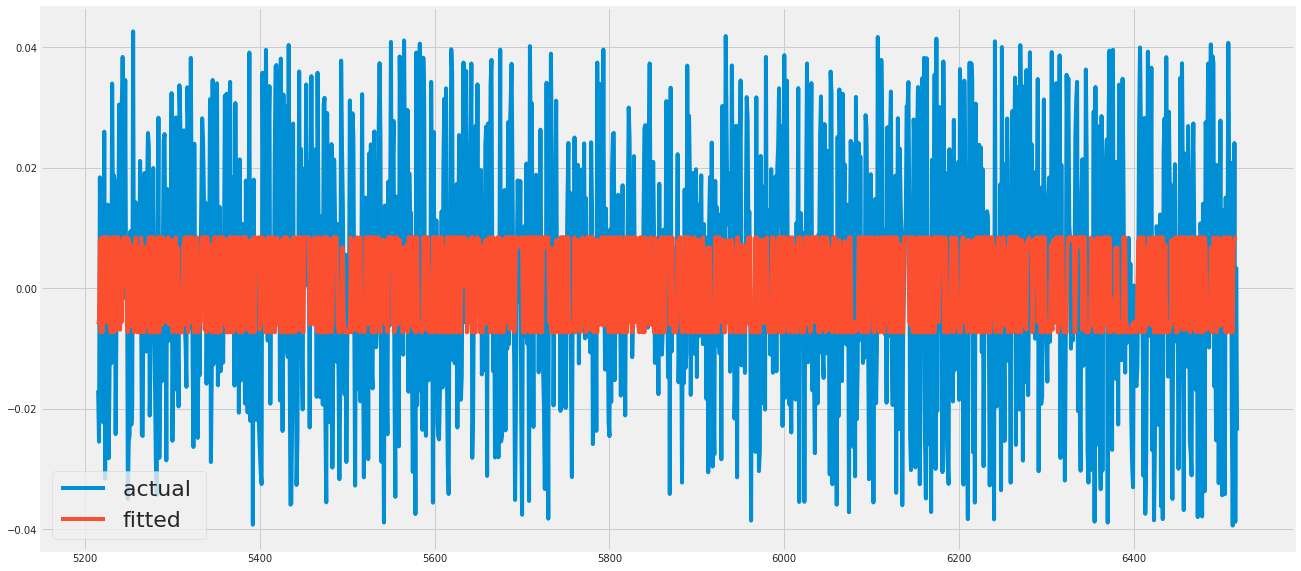

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)

# plt.scatter(test.Close, test.xg)

plt.plot(test.Close, label='actual ')
plt.plot(test.lgbm, label='fitted')
plt.legend(prop={'size': 22})
plt.show()

In [ ]:
def rmse_tab(y_actual, y_pred):
  result = []
  for i in range(0, int(len(y_actual))):
    MSE = np.square(np.subtract(y_actual.iloc[i], y_pred.iloc[i])).mean() 
    RMSE = math.sqrt(MSE)
    result.append(RMSE)
  rmse = pd.DataFrame(data=result, columns=['RMSE'])

  return rmse

In [ ]:
rmse_lg = rmse_tab(test.Close, test.lgbm)
rmse_xg = rmse_tab(test.Close, test.xg)
rmse_ada = rmse_tab(test.Close, test.ada)
rmse_cat = rmse_tab(test.Close, test.cat)

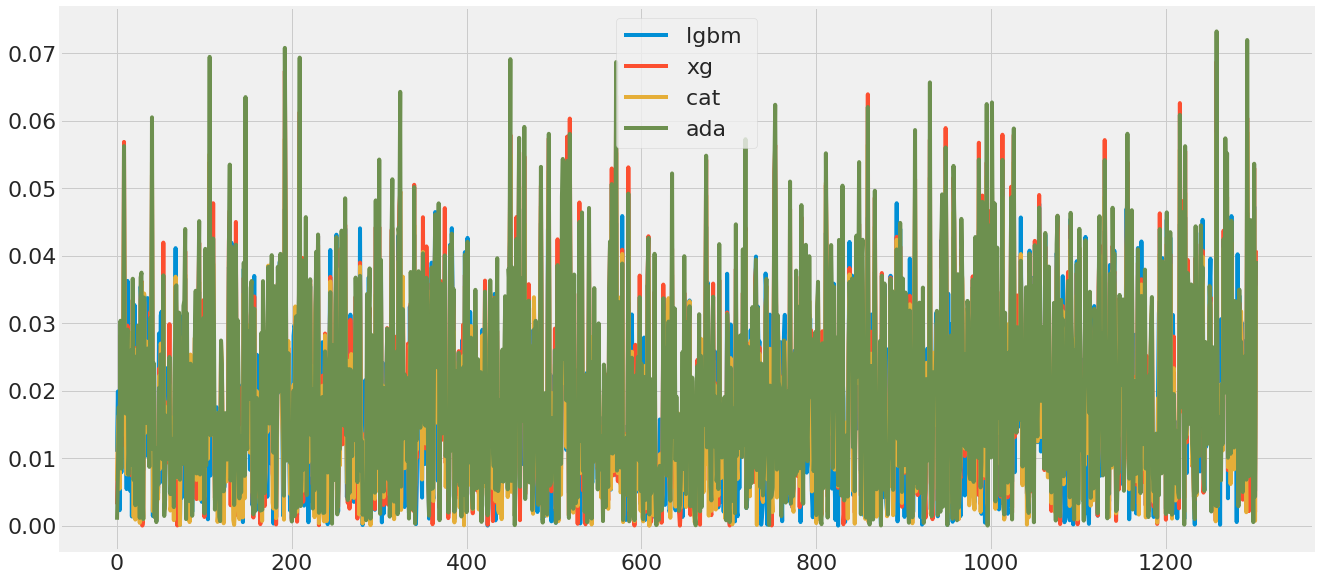

In [ ]:
fig, ax = plt.subplots(figsize=(100,10))
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)

# plt.scatter(test.Close, test.xg)

plt.plot(rmse_lg, label='lgbm ')
plt.plot(rmse_xg, label='xg')
plt.plot(rmse_cat, label='cat ')
plt.plot(rmse_ada, label='ada')
plt.legend(prop={'size': 22})
plt.show()